In [0]:
!pip install tensorflow-gpu==2.0.0rc numpy tqdm matplotlib --no-cache-dir

     |████████████████████████████████| 380.5MB 1.2MB/s 
     |████████████████████████████████| 501kB 58.4MB/s 
     |████████████████████████████████| 4.3MB 54.3MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import folium
import datetime as dt
import dateutil.parser
import random as rand
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras import metrics 


tf.__version__

'2.0.0-rc0'

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,8,9,10,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


12096
378
378
[[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0],

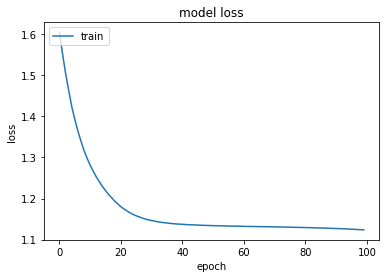

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 50)                1650      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 55        
Total params: 2,215
Trainable params: 2,215
Non-trainable params: 0
_________________________________________________________________


In [0]:

# This is an object class to store all the data about storms :) 
class storm(object):

  def __init__(self,name,sid,lat,longi,basin,sub_basin,times,wind,pres): 
    # Note: the lat, long, times, wind, and pres are all arrays across the duration of a storm! 
    self.sid = sid # unique ID number associated with year/number of storm 
    self.name = name # Hurricane Name
    self.lat = lat # Hurricane Latitude, array of all 
    self.longi = longi # Hurricane Longitude, array of all 
    self.basin = basin # Hurricane basin, by 2-lettter code 
    self.sub_basin = sub_basin
    self.times = times #Hurricane times 
    self.wind = wind # array of all 
    self.pres = pres # array of all 
    windmax = max(self.wind)
    if windmax > 136 : 
      self.strclass = 5
    elif windmax > 112:
      self.strclass = 4
    elif windmax > 95:
      self.strclass = 3
    elif windmax > 82:
      self.strclass = 2
    else :
      self.strclass = 1


  def Get_Maxs(this):
    maxLat = max(this.lat)
    maxLong = max(this.longi)
    maxWind = max(this.wind)
    maxPres = max(this.pres)
    return maxLat, maxLong, maxWind, maxPres

  def Get_Mins(this):
    minLat = min(this.lat)
    minLong = min(this.longi)
    minWind = min(this.wind)
    minPres = min(this.pres)
    return minLat, minLong, minWind, minPres


  def CleanStorm(this,interval):
    toRemove = []
    i = 1
    lastCleanTime = this.times[0]
    # check if the last correct time minus the current time is in the correct interval
    while(i < len(this.times)):
      nextTime = this.times[i]
      tDelta = nextTime - lastCleanTime
      if tDelta==interval:
        lastCleanTime = nextTime
      else:
        toRemove.append(i)
      i += 1
    # reverse sort to not mess up the indices 
    toRemove.sort(reverse=True)
    # Remove the bad data
    for r in toRemove:
      this.times.pop(r)
      this.longi.pop(r)
      this.lat.pop(r)
      this.wind.pop(r)
      this.pres.pop(r)      

# This function sorts imported data into storms :) 
def stormify(dataset):
  storm_list = []
  item = dataset[0] 
  stormno = item[2]
  name = item[5] 
  sid = str(item[1]*1000 + item[2])
  lat = []
  longi = []
  basin = str.strip(item[3])
  sub_basin = str.strip(item[4])
  times = []
  wind = []
  pres = []
  for item in dataset: 
    # Case 1 - New storm 
    # Create an object for the old storm, re-initialize everything 
    if (item[2] != stormno):
      # Create an object for the given SID 
      storm_list.append(storm(name, sid, lat, longi, basin,sub_basin, times, wind, pres))
      # Reset Values with new data
      stormno = item[2]
      name = item[5] 
      sid = str(item[1]*1000 + item[2])
      lat = [item[8]]
      longi = [item[9]]
      basin = str.strip(item[3])
      sub_basin = str.strip(item[4])
      times = [dateutil.parser.parse(item[6])]
      wind = [item[10]]
      pres = [item[11]]
    # Case 2 - Same old storm 
    else:
      lat.append(item[8])
      longi.append(item[9])
      times.append(dateutil.parser.parse(item[6]))
      wind.append(item[10])
      pres.append(item[11])
  return storm_list

def normalize(x, mx, mn):
  return (x-mn)/(mx-mn)

def normalize_col(col,maxV,minV):
  for i in range(len(col)):
    col[i] = normalize(col[i],maxV,minV)
  return col

def normalize_storms(storms):
  maxLats = []
  maxLongs = []
  maxWinds = []
  maxPress = []

  minLats = []
  minLongs = []
  minWinds = []
  minPress = []

  for s in storms:
    maLa , maLo , maWi, maPr = s.Get_Maxs()
    maxLats.append(maLa)
    maxLongs.append(maLo)
    maxWinds.append(maWi)
    maxPress.append(maPr)

    miLa, miLo, miWi, miPr = s.Get_Mins()
    minLats.append(miLa)
    minLongs.append(miLo)
    minWinds.append(miWi)
    minPress.append(miPr)

  maxs = [max(maxLats),max(maxLongs),max(maxWinds),max(maxPress)]
  mins = [min(minLats),min(minLongs),min(minWinds),min(minPress)]

  for s in storms:
    s.lat = normalize_col(s.lat,maxs[0],mins[0])
    s.longi = normalize_col(s.longi,maxs[1],mins[1])
    s.wind = normalize_col(s.wind,maxs[2],mins[2])
    s.pres = normalize_col(s.pres,maxs[3],mins[3])

  return storms, maxs, mins

def remove_small_storms(storm_list,cutoff):
  refined_storms = []
  for storm in storm_list:
    if len(storm.longi) >= cutoff:
      refined_storms.append(storm)
  return refined_storms 

def selectBasin(storm_list, basin): 
  chosen_basin = []
  for storm in storm_list: 
    if basin==storm.basin: 
      chosen_basin.append(storm)
  return chosen_basin

def onehot(values): 
  aa = []
  for value in values: 
    a = [0,0,0,0,0]
    a[value-1] = 1
    aa.append(a)
  print(aa)
  aaarray = np.asarray(aa)
  print(aaarray)
  return aaarray

def network_friendly_storms(storm_list, timesteps): 
  x_list = []
  y_list = [] 
  for storm in storm_list:
    #storm.wind[0:timesteps] + storm.pres[0:timesteps] + storm.lat[0:timesteps] + storm.longi[0:timesteps] 
    for i in range(timesteps):
      x_list.append(storm.wind[i])
      x_list.append(storm.pres[i])
      x_list.append(storm.lat[i])
      x_list.append(storm.longi[i])
      #x_list.append()
    y_list.append(storm.strclass)
  print(len(x_list))
  print(len(y_list))
  print(len(storm_list))
  x_array = np.asarray(x_list,dtype=float)
  x_proper = x_array.reshape((4*timesteps,len(storm_list)))
  y_array = onehot(y_list)
  return x_array, y_array

#------------------------------------------------------------------------------#
#                        Data Visualization Stuff                              #
def mapStorms_NA(storm_list): 
  basin_map = folium.Map(location=[30, -50], control_scale=True, zoom_start=4)
  fcolors = ['white','green','yellow','orange','red','black']
  i = 0 
  for storm in storm_list: 
    i = (i+1)%19
    points = zip(storm.lat, storm.longi)

    folium.PolyLine(list(points), color=fcolors[storm.strclass], weight=2.5, opacity=1).add_to(basin_map)
  return basin_map

#------------------------------------------------------------------------------#
#                        Actual Model                                          #

class Hurricane_Model:
  def __init__(self, train_x, train_y,test_x,test_y, maxV, minV,name):
    self.maxV = maxV
    self.minV = minV 
    self.train_x = train_x
    self.train_y = train_y
    self.test_x = test_x
    self.test_y = test_y
    self.name = name
    self.input_dim = len(self.train_x[0])
    self.output_dim = 5

    print("Shell Created:",self.name)

  def unNormalize(self,d):
    orig = d * (self.maxV - self.minV) + self.minV
    return orig
  
  def CreateModel(self,layer1,layer2,opt):
    model = Sequential()
    model.add(Dense(layer1,input_dim=self.input_dim,activation='sigmoid'))
    model.add(Dense(layer2, activation='sigmoid')) 
    model.add(Dense(self.output_dim, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    
    self.model = model
    print("Model Created:",self.name)

  def TrainModel(self,split,epochs,batchsize):
    print("Training Model:",self.name)
    self.estimator = KerasClassifier(build_fn=self.model, epochs=200, batch_size=5, verbose=1)
    self.history = self.model.fit(self.train_x, self.train_y, batch_size=None, epochs=100, verbose=1, callbacks=None, validation_split=0.2)
    self.__plotHistory(self.history)
    
  def EvaluateModel(self):
    print("Evaluating Model:",self.name)
    predictions = self.estimator.predict(self.test_x)
    actual = (self.test_y)
    print(predictions)
    print(actual)

  def __plotHistory(self,history):
    # "Loss"
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


#------------------------------------------------------------------------------#
#                          Execution of data import                            #

# Import the raw IBtracs hurricane data stored on GitHub
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/Allstorms.ibtracs_wmo.v03r10.csv'
dataframe = pd.read_csv(url, header = 1)
dataset = dataframe.values
dataset_1980p = dataset[92144:len(dataset)] #import all storms after 1980 
all_storms = stormify(dataset_1980p) # Make storms into Object 
for storm in all_storms: 
  storm.CleanStorm(dt.timedelta(seconds=6*60*60))# Remove time intervals that are not 6 hours
big_storms = remove_small_storms(all_storms, 16) # Remove storms that lasted for fewer than 48 hours
NAstorms = selectBasin(big_storms,'NA') #Select only North American basin storms

map = mapStorms_NA(NAstorms) # Map all the North American storms that we have found
normNAstorms, maxs, mins = normalize_storms(NAstorms)
display(map)
x_data, y_data = network_friendly_storms(normNAstorms, 8)
x_shaped = x_data.reshape(len(y_data),32)

valsplit = int(0.8*len(x_shaped))

train_x = x_shaped[:valsplit]
train_y = y_data[:valsplit]
test_x = x_shaped[valsplit+1:]
test_y = y_data[valsplit+1:]

intensity_prediction_model = Hurricane_Model(train_x, train_y, test_x, test_y, maxs, mins, "Intensity Model")
opt = tf.keras.optimizers.Adam()
intensity_prediction_model.CreateModel(50,10,opt)
intensity_prediction_model.TrainModel(0.8,100,50)
intensity_prediction_model.model.summary()

#intensity_prediction_model.EvaluateModel()

In [0]:
#intensity_prediction_model.model.fit(train_x, train_y)
print(intensity_prediction_model.model.predict(test_x))
print(test_y)

[[0.88455844 0.1640619  0.14533007 0.15292194 0.04337463]
 [0.8570373  0.16955262 0.15551952 0.17192805 0.04272908]
 [0.8592212  0.16891566 0.1546154  0.17056656 0.04256877]
 [0.8629918  0.16844112 0.15328762 0.16807836 0.04273272]
 [0.8596568  0.16906038 0.15457904 0.17025375 0.0427483 ]
 [0.8609825  0.16846398 0.15385479 0.16952345 0.04243642]
 [0.8591215  0.16881236 0.15451744 0.17073265 0.04240963]
 [0.8678186  0.16789865 0.1516858  0.16474527 0.04312831]
 [0.8635673  0.16795847 0.15286514 0.16775453 0.04244849]
 [0.8766562  0.16542327 0.14798352 0.15888217 0.04268044]
 [0.86407423 0.16853186 0.15280902 0.16747469 0.0427767 ]
 [0.8693954  0.16764027 0.15115422 0.1636625  0.04320949]
 [0.8557179  0.1700637  0.15597364 0.17287615 0.04277435]
 [0.8866384  0.16345054 0.144485   0.1514059  0.04336554]
 [0.8826259  0.16401246 0.14575145 0.15448523 0.04284337]
 [0.8653115  0.16783339 0.15214294 0.16674185 0.04246119]
 [0.85350454 0.17037663 0.15708014 0.17403257 0.04300401]
 [0.8851613  0